In [1]:
from matplotlib import pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc, accuracy_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.multioutput import MultiOutputClassifier
from itertools import cycle
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay

In [2]:
dataset = pd.read_csv("/kaggle/input/combineddata/combinedBalancedDataset.csv", header = None, delimiter = ',')
print(dataset)

        0   1   2   3   4    5   6    7    8   9   ...  20  21   22  23  24  \
0        3   8  34  40  83   34  71    3    2  55  ...   3   2   38  26   3   
1       19  27  36   6  23    8   1   63   40  38  ...  63  12   47  14  16   
2       16  47  98   9  50    7  17  112   50  46  ...  16  17   44  33  55   
3       30  84   5  23  43   33   3   39  121  85  ...   3  32   59  63  55   
4       19  20  61  14   4    8   4   76   14  44  ...  76  14   52  21   6   
...     ..  ..  ..  ..  ..  ...  ..  ...  ...  ..  ...  ..  ..  ...  ..  ..   
213563  35  79  28  25  45  126   5   43  102  21  ...   4  45   82  12  61   
213564  15  32  37  12   2   12   1   64   23  46  ...  64   9   46  12  47   
213565  90  66   8  62  10   84  32   60   45  97  ...  10  20   22  75  50   
213566  16  42  98   9  57    6  17  112   49  46  ...  78  48  110  13  60   
213567  20  21  28   9  20   40  19   16   42  22  ...  69  33   67  47  49   

        25  26  27  28  29  
0       56   1   1   0

In [3]:
X = dataset.drop(columns = [26,27,28,29])
y = dataset.filter([26,27,28,29])
print("X of the dataset: \n",X)
print("y of the dataset: \n", y)

X of the dataset: 
         0   1   2   3   4    5   6    7    8   9   ...  16  17   18  19  20  \
0        3   8  34  40  83   34  71    3    2  55  ...   2  55   34  71   3   
1       19  27  36   6  23    8   1   63   40  38  ...  40  36    8   4  63   
2       16  47  98   9  50    7  17  112   50  46  ...   9  50    1  63  16   
3       30  84   5  23  43   33   3   39  121  85  ...  26  33   33  20   3   
4       19  20  61  14   4    8   4   76   14  44  ...   3  37    8  28  76   
...     ..  ..  ..  ..  ..  ...  ..  ...  ...  ..  ...  ..  ..  ...  ..  ..   
213563  35  79  28  25  45  126   5   43  102  21  ...  25  45  108  14   4   
213564  15  32  37  12   2   12   1   64   23  46  ...  14  43   18   1  64   
213565  90  66   8  62  10   84  32   60   45  97  ...  13   6   84  32  10   
213566  16  42  98   9  57    6  17  112   49  46  ...   9  57   27  17  78   
213567  20  21  28   9  20   40  19   16   42  22  ...   9  20   22  19  69   

        21   22  23  24  25  
0

In [4]:
#max_score = 0
#best_estimator = 50
#best_learning_rate = 1.0
#n_estimator_list = [50,100,150,200]
#learning_rate_list = [1.0,2.0,3.0]

#for e in n_estimator_list:
    #for l in learning_rate_list:
abc = AdaBoostClassifier(n_estimators = 200,learning_rate = 1.0)
classifier = MultiOutputClassifier(abc)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(classifier, X, y, cv=kfold)
score_mean = score.mean()
f1_scorer = make_scorer(f1_score, average='micro')
f1_score_value = cross_val_score(classifier, X, y, cv=kfold, scoring= f1_scorer)
    #if score_mean > max_score:
            #best_scores = score
            #max_score = score_mean
            #best_estimator = e
            #best_learning_rate = l

In [5]:
print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.8f}".format(score_mean))
print("Standard Deviation of scores: {:.8f}".format(score.std()))
#print("Best n_estimator and learning rate: ", best_estimator, best_learning_rate)

Cross-validation scores: [0.24027251 0.24298825 0.2394297  0.24112097 0.24187016]
Average cross-validation score: 0.24113632
Standard Deviation of scores: 0.00123508


In [6]:
f1_score_final = f1_score_value.mean()
print("Average F1 score:", f1_score_final)

Average F1 score: 0.6815823644493186


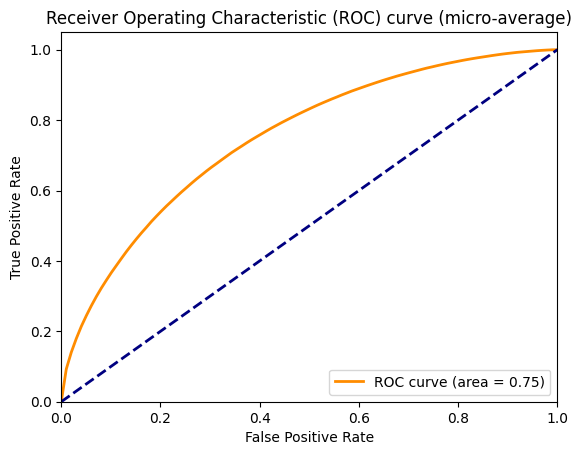

In [7]:
#After you train model, these blocks of code make tpr, fpr, precision and recall from it
#I hypertuned it separately to get the best parameters, and once I had the best ones, I used them directly as is
# Initialize variables to store fpr and tpr
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
mean_roc_auc = 0.0

# Iterate over folds
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit classifier and predict probabilities
    classifier.fit(X_train, y_train)
    probs = classifier.predict_proba(X_test)
    
    # Compute ROC curve for each class
    for i in range(y.shape[1]):
        fpr, tpr, _ = roc_curve(y_test.iloc[:, i], probs[i][:, 1])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        mean_roc_auc += auc(fpr, tpr)

# Normalize mean_tpr and mean_auc
mean_tpr /= kfold.n_splits * y.shape[1]
mean_roc_auc /= kfold.n_splits * y.shape[1]

# Plot micro-average ROC curve
plt.figure()
plt.plot(all_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % mean_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve (micro-average)')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/abc_5CV_roc_real_smote.png')
plt.show()

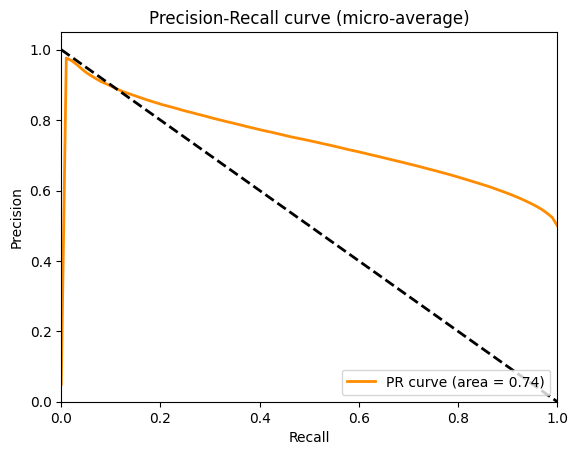

In [8]:
all_recall = np.linspace(0, 1, 100)
mean_precision = 0.0
mean_prc_auc = 0.0

# Iterate over folds
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit classifier and predict probabilities
    classifier.fit(X_train, y_train)
    probs = classifier.predict_proba(X_test)
    
    # Compute precision-recall curve for each class
    for i in range(y.shape[1]):
        precision, recall, _ = precision_recall_curve(y_test.iloc[:, i], probs[i][:, 1])
        mean_precision += np.interp(all_recall, recall[::-1], precision[::-1])
        mean_precision[0] = 1.0
        mean_prc_auc += auc(recall, precision)

# Normalize mean_precision and mean_auc
mean_precision /= kfold.n_splits * y.shape[1]
mean_prc_auc /= kfold.n_splits * y.shape[1]
# Plot micro-average precision-recall curve
plt.figure()
plt.plot(all_recall, mean_precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % mean_prc_auc)
plt.plot([0,1],[1,0], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (micro-average)')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/abc_5CV_prc_real_smote.png')
plt.show()

In [9]:
print(all_fpr)
print(mean_tpr)
print(all_recall)
print(mean_precision)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

In [10]:
output_file_path = '/kaggle/working/adaboost_real_smote_scores.txt'
with open(output_file_path, 'w') as f: 
    f.write("F1 Score: {}\n".format(f1_score_final))
    f.write("Precision: {}\n".format(mean_precision)) 
    f.write("Recall: {}\n".format(all_recall)) 
    f.write("PRC AUC: {}\n".format(mean_prc_auc)) 
    f.write("ROC AUC: {}\n".format(mean_roc_auc)) 
    f.write("TPR: {}\n".format(mean_tpr)) 
    f.write("FPR: {}\n".format(all_fpr))